# Fig 1 sideways
- network correlation matrix with left bound names
- three tier model precision view
- brain networks color coded by ensembles
- association between ASD conformal scores and behavioural metrics

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import pathlib as pal
import scipy as sp
import seaborn as sbn
import nibabel as nib
from scipy import cluster as scl
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from nilearn import plotting as nlp
import nilearn.input_data as nii
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [6]:
root_p = pal.Path('/home/surchs/Repositories/autismclassification/')
pheno_p = root_p / 'Data/Sebastian Urchs - ABIDE1_Pheno_PSM_matched.tsv'
labels_p =  '/home/surchs/GDrive/SCI/Paper/ASD_univariate/data_abide_univariate/ATLAS/MIST/Parcel_Information/MIST_20_nocereb.csv'
comb_net_p0_p = '/home/surchs/combined_networks_{}_p0.tsv'
comb_net_p1_p = '/home/surchs/combined_networks_{}_p1.tsv'
atlas_p = '/home/surchs/GDrive/SCI/Paper/MIST/Release/Parcellations/MIST_20.nii.gz'
mask_p = '/home/surchs/GDrive/SCI/Paper/MIST/Release/Parcellations/MIST_mask.nii.gz'
split_net_p0_p = '/home/surchs/split_net_{}_p0.tsv'
split_net_p1_p = '/home/surchs/split_net_{}_p1.tsv'
all_net_p0_p = '/home/surchs/combined_networks_8_p0.tsv'
all_net_p1_p = '/home/surchs/combined_networks_8_p1.tsv'
data_t = root_p / 'Data/Results_Instance_{}_Network_{}.csv'

#fig_p = pal.Path('/home/surchs/VM_Folders/P3_figures/fig1/')
#if not fig_p.is_dir():
#    fig_p.mkdir()

In [8]:
pheno = pd.read_csv(pheno_p, sep='\t')
atlas_i = nib.load(atlas_p)
mask_i = nib.load(mask_p)
has_autism = (pheno.DX_GROUP=='Autism').values.astype(int)
network_labels = pd.read_csv(labels_p, sep=';')

voxel_masker = nii.NiftiMasker(mask_img=mask_i, standardize=False)
voxel_masker.fit()

NiftiMasker(detrend=False, dtype=None, high_pass=None, low_pass=None,
            mask_args=None,
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f179c274880>,
            mask_strategy='background', memory=Memory(location=None),
            memory_level=1, reports=True, sample_mask=None, sessions=None,
            smoothing_fwhm=None, standardize=False, t_r=None,
            target_affine=None, target_shape=None, verbose=0)

In [23]:
results_array = np.stack([[pd.read_csv(str(data_t).format(instance+1, net+1)).values[:, 1:] 
                           for instance in range(100)] 
                          for net in range(18)], -1)

In [11]:
easy_names = ["bas. gangl.","vent. soma.mot.","orb.front. ctx",
              "VMPFC","inf. temp. gyr.","task control",
              "auditory","med. visual","amygd. hippocamp.",
              "dors. soma.mot.","vent. att.","ant. DMN","post.med. DMN",
              "lat. visual","dwnstrm visual","lat. DMN","lat. vent. att.","front.-par."]

In [12]:
network_labels['easy'] = easy_names

In [13]:
def mm2in(mm):
    return mm/25.4

# Remember: those are R-indices -> they start at 1 and go to 410

In [14]:
manual_network_order = [18, 
                        3, 9, 5, 16, 
                        1, 
                        13, 4, 12,
                        2, 7, 10,
                        11, 6, 17,
                        8, 14, 15]
data_order = np.array([12, 3, 11, 0, 2, 8, 4, 15, 17, 7, 13, 14, 10, 16, 5, 9, 6, 1])+1
man_order = np.array(manual_network_order)
#man_order = np.array(data_order)

In [36]:
bootstrap_order = results_array[:, :, 1, 0].astype(int) - 1

## Individual networks

In [29]:
precision = np.zeros(shape=(100, 18))
specificity = np.zeros(shape=(100, 18))
sensitivity = np.zeros(shape=(100, 18))

thr = 0.05

for iteration in range(100):
    for net in range(18):
        test = results_array[iteration, ..., net]
        
        labels = (pheno.iloc[(test[:, 1]-1).astype(int)].DX_GROUP=='Autism').values.astype(int)
        prediction_region = (test[:, 2] > thr) & (test[:, 3] <= thr)

        p = sum(labels==1)
        n = sum(labels==0)
        tp = sum(labels[prediction_region]==1)
        fp = sum(labels[prediction_region]==0)
        tn = sum(labels[~prediction_region]==0)
        fn = sum(labels[~prediction_region]==1)
        # Compute stuff
        sens = tp / p
        spec = tn / n
        ppv = tp / (tp+fp)
        npv = tn / (tn + fn)
        fpr = fp / n
        fdr = fp / (fp + tp)
        
        precision[iteration, net] = ppv
        specificity[iteration, net] = spec
        sensitivity[iteration, net] = sens

In [38]:
table = pd.DataFrame([(p, spec, sens, n)  
                      for net in range(18) for p, spec, sens, n in 
                      [(precision[i, net], 
                        specificity[i, net],
                        sensitivity[i, net],
                        network_labels.iloc[net]['label']) for i in range(100)]],
                     columns=('precision', 'specificity', 'sensitivity', 'network'))


manual_partition = [0, 
                    1, 1, 1, 1, 
                    2, 
                    3, 3, 3, 
                    4, 4, 4,
                    5, 5, 5,
                    6, 6, 6]
network_names_ordered = [network_labels.loc[o]['label'] for o in man_order-1 ]
group_mapping = {n: f'group_{p+1}' for n, p in zip(network_names_ordered, 
                                 manual_partition)}

table['group'] = [group_mapping[row['network']] for rid, row in table.iterrows()]

# Get me the table index ordered like the networks

table_order = [i for n in network_names_ordered for i in table.query(f'network=="{n}"').index]

table['group'] = [group_mapping[row['network']] for rid, row in table.iterrows()]

## Combined networks

In [51]:
handles=precision_combined = np.zeros(shape=(100, 7))
specificity_combined = np.zeros(shape=(100, 7))
sensitivity_combined = np.zeros(shape=(100, 7))

thr = 0.2

for net in range(7):
    p1 = pd.read_csv(comb_net_p1_p.format(net+1), sep='\t')
    p0 = pd.read_csv(comb_net_p0_p.format(net+1), sep='\t')
    for iteration in range(100):
        # Get the right bootstrap order
        bo = bootstrap_order[iteration, :]
        labels = (pheno.iloc[bo].DX_GROUP=='Autism').values.astype(int)
        prediction_region = (p1.values[:, iteration] > thr) & (p0.values[:, iteration] <= thr)

        p = sum(labels==1)
        n = sum(labels==0)
        tp = sum(labels[prediction_region]==1)
        fp = sum(labels[prediction_region]==0)
        tn = sum(labels[~prediction_region]==0)
        fn = sum(labels[~prediction_region]==1)
        # Compute stuff
        sens = tp / p
        spec = tn / n
        ppv = tp / (tp+fp)
        npv = tn / (tn + fn)
        fpr = fp / n
        fdr = fp / (fp + tp)

        precision_combined[iteration, net] = ppv
        specificity_combined[iteration, net] = spec
        sensitivity_combined[iteration, net] = sens

In [52]:
table_combined = pd.DataFrame([(p, spec, sens, n)  
                      for net in range(7) for p, spec, sens, n in 
                      [(precision_combined[i, net], 
                        specificity_combined[i, net],
                        sensitivity_combined[i, net],
                        f'group_{net+1}') for i in range(100)]],
                     columns=('precision', 'specificity', 'sensitivity', 'network'))

## Split networks
The two big network groups

In [55]:
handles=precision_split = np.zeros(shape=(100, 7))
specificity_split = np.zeros(shape=(100, 7))
sensitivity_split = np.zeros(shape=(100, 7))

thr = 0.2

for net in range(2):
    p1 = pd.read_csv(split_net_p1_p.format(net+1), sep='\t')
    p0 = pd.read_csv(split_net_p0_p.format(net+1), sep='\t')
    for iteration in range(100):
        # Get the right bootstrap order
        bo = bootstrap_order[iteration, :]
        labels = (pheno.iloc[bo].DX_GROUP=='Autism').values.astype(int)
        prediction_region = (p1.values[:, iteration] > thr) & (p0.values[:, iteration] <= thr)

        p = sum(labels==1)
        n = sum(labels==0)
        tp = sum(labels[prediction_region]==1)
        fp = sum(labels[prediction_region]==0)
        tn = sum(labels[~prediction_region]==0)
        fn = sum(labels[~prediction_region]==1)
        # Compute stuff
        try:
            sens = tp / p
            spec = tn / n
            ppv = tp / (tp+fp)
            npv = tn / (tn + fn)
            fpr = fp / n
            fdr = fp / (fp + tp)
        except ZeroDivisionError:
            replace = 0
            sens = replace
            spec = replace
            ppv = replace
            npv = replace
            fpr = replace
            fdr = replace

        precision_split[iteration, net] = ppv
        specificity_split[iteration, net] = spec
        sensitivity_split[iteration, net] = sens

In [56]:
table_split = pd.DataFrame([(p, spec, sens, n)  
                      for net in range(2) for p, spec, sens, n in 
                      [(precision_split[i, net], 
                        specificity_split[i, net],
                        sensitivity_split[i, net],
                        f'group_{net+1}') for i in range(100)]],
                     columns=('precision', 'specificity', 'sensitivity', 'network'))

In [57]:
# Make a correlation matrix of the asd probabilities for each instance
corr_mat = np.stack([np.corrcoef(results_array[instance, :, 2, :].T) for instance in range(100)], -1)

In [17]:
avg_weight_corr = np.average(corr_mat, 2)

In [18]:
#sim = np.corrcoef(data_stack)
sim = np.average(corr_mat, 2)
dist = 1 - sim[np.triu(np.ones(shape=sim.shape), 1).astype(bool)]
link = scl.hierarchy.linkage(dist, method='average', optimal_ordering=True)
order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']

In [19]:
def get_patches(mat, part, c='black'):
    tab = pd.DataFrame(data=part, columns=('part',))
    val, ind_start, ind_stop = zip(*[(u, 
                                      tab.query(f'part=={u}').first_valid_index(),
                                      tab.query(f'part=={u}').last_valid_index()) for u in tab.part.unique()])
    patch_list = list()
    for ii in range(0,len(ind_start)):
        p = mpl.patches.Rectangle((ind_start[ii]-0.5,)*2,
                                  ind_stop[ii]-ind_start[ii]+1,
                                  ind_stop[ii]-ind_start[ii]+1,
                                                 angle=0, 
                                                 edgecolor=c,
                                                 facecolor='none' ,
                                                 linewidth=4)
        patch_list.append(p)
    return patch_list

In [20]:
def get_better_patches(mat, part, c):
    tab = pd.DataFrame(data=part, columns=('part',))
    val, ind_start, ind_stop = zip(*[(u, 
                                      tab.query(f'part=={u}').first_valid_index(),
                                      tab.query(f'part=={u}').last_valid_index()) for u in tab.part.unique()])
    patch_list = list()
    print(list(zip(val, c)))
    for ii in range(0,len(ind_start)):
        if val[ii]==0:
            continue
        p = mpl.patches.Rectangle((ind_start[ii]-0.5,)*2,
                                  ind_stop[ii]-ind_start[ii]+1,
                                  ind_stop[ii]-ind_start[ii]+1,
                                                 angle=0, 
                                                 #edgecolor=sbn.xkcd_rgb[c[ii]],
                                                 edgecolor=c[ii],
                                                 facecolor='none' ,
                                                 linewidth=2)
        patch_list.append(p)
    return patch_list

In [21]:
colors = [sbn.xkcd_rgb[col] for col in 
         ['amber', 'heather', 'lemon', 'dark sky blue', 'pale rose', 'easter green', 'khaki']]

In [22]:
order = np.array([18,  3,  9,  5, 16,  1, 13,  4, 12,  2,  7, 10, 11,  6, 17,  8, 14,
       15])-1

In [23]:
# Manual partition
part_dict = {1: [18],
             2: [3, 9, 5, 16],
             3: [1],
             4: [13, 4, 12],
             5: [2, 7, 10],
             6: [11, 6, 17],
             7: [8, 14, 15]
            }
manual_part = np.array([p for i in order  for p, v in part_dict.items() if i+1 in v])

## Describe the networks

In [25]:
def get_extreme(table, var):
    max_net = table.groupby('network')[var].describe()['50%'].idxmax()
    print(var, ' max: ', max_net, table.query('network==@max_net')[var].median())
    min_net = table.groupby('network')[var].describe()['50%'].idxmin()
    print(var, ' min: ', min_net, table.query('network==@min_net')[var].median())

In [27]:
get_extreme(table, 'precision')
get_extreme(table, 'sensitivity')
get_extreme(table, 'specificity')

precision  max:  FPTCnet 0.6666666666666666
precision  min:  ORBcor_NACC 0.5611895592640137
sensitivity  max:  MOTnet_d 0.1794193740412574
sensitivity  min:  ORBcor_NACC 0.12200847360586281
specificity  max:  FPTCnet 0.9168586789554531
specificity  min:  MOTnet_d 0.9022504400301735


In [28]:
# Show me the group level
for group in part_dict.keys():
    print()
    for val in ['precision', 'specificity', 'sensitivity']:
        group_val = table_combined.query(f'network == "group_{group}"')[[val]].describe().T['50%'].values[0]
        net_val = table.query(f'group == "group_{group}"')[[val, 'network']].groupby('network').median().mean().values[0]
        print(f'{val}: group_{group}: {group_val*100:.1f}% vs individual: {net_val*100:.1f}%')


precision: group_1: 61.4% vs individual: 63.8%
specificity: group_1: 96.4% vs individual: 90.4%
sensitivity: group_1: 6.0% vs individual: 15.1%

precision: group_2: 69.7% vs individual: 61.1%
specificity: group_2: 96.8% vs individual: 90.8%
sensitivity: group_2: 7.7% vs individual: 14.6%

precision: group_3: 60.6% vs individual: 63.9%
specificity: group_3: 82.5% vs individual: 90.7%
sensitivity: group_3: 26.6% vs individual: 15.7%

precision: group_4: 69.2% vs individual: 64.8%
specificity: group_4: 92.3% vs individual: 91.0%
sensitivity: group_4: 15.9% vs individual: 16.1%

precision: group_5: 64.8% vs individual: 63.7%
specificity: group_5: 89.8% vs individual: 90.7%
sensitivity: group_5: 19.5% vs individual: 16.5%

precision: group_6: 59.0% vs individual: 65.3%
specificity: group_6: 86.6% vs individual: 91.3%
sensitivity: group_6: 18.9% vs individual: 15.8%

precision: group_7: 63.4% vs individual: 61.9%
specificity: group_7: 87.7% vs individual: 90.8%
sensitivity: group_7: 21.9% v

In [29]:
# ens_colors = ['#FE9D08', '#1258A6'] # Orange, Blue

In [30]:
# Show me the ensemble
print('ensemble 1')
for val in ['precision', 'specificity', 'sensitivity']:
    group_val = table_split.query(f'network == "group_1"')[[val]].describe().T['50%'].values[0]
    net_val = table.query(f'group in ["group_1", "group_2", "group_3", "group_4"]')[[val, 'network']].groupby('network').median().mean().values[0]
    print(f'{val}: ens1: {group_val*100:.1f}% vs individual: {net_val*100:.1f}%')
    
# Show me the ensemble
print('ensemble 2')
for val in ['precision', 'specificity', 'sensitivity']:
    group_val = table_split.query(f'network == "group_2"')[[val]].describe().T['50%'].values[0]
    net_val = table.query(f'group in ["group_4", "group_5", "group_6"]')[[val, 'network']].groupby('network').median().mean().values[0]
    print(f'{val}: ens2: {group_val*100:.1f}% vs individual: {net_val*100:.1f}%')

ensemble 1
precision: ens1: 88.7% vs individual: 62.9%
specificity: ens1: 99.5% vs individual: 90.8%
sensitivity: ens1: 4.9% vs individual: 15.3%
ensemble 2
precision: ens2: 72.0% vs individual: 64.6%
specificity: ens2: 97.1% vs individual: 91.0%
sensitivity: ens2: 7.4% vs individual: 16.1%


## Horizontal individual

In [26]:
# Manual partition
part_dict = {1: [18],
             2: [3, 9, 5, 16],
             3: [1],
             4: [13, 4, 12],
             5: [2, 7, 10],
             6: [11, 6, 17],
             7: [8, 14, 15]
            }
manual_part = np.array([p for i in order  for p, v in part_dict.items() if i+1 in v])
order = np.array([18,  3,  9,  5, 16,  1, 13,  4, 12,  2,  7, 10, 11,  6, 17,  8, 14,
       15])-1

In [27]:
# Ensemble colors
ens_colors = ['#FE9D08', '#1258A6'] # Orange, Blue
group_7_colors = ['#FFB647', # Light Orange
                  '#FE2908', # Bright Red
                  '#BF7400', # Burnt Orange
                  '#FED908', # Bright Yellow
                  '#52DD07', # Green
                  '#1258A6', # Blue (same color as above)
                  '#5E12AC'] # Purple
group_18_colors = ['#FFB647', # Light Orange
                   '#FF907E', '#FF6047', '#BF1A00', '#881200', # 2nd group, shades of red
                  '#BF7400', # Burnt Orange
                  '#FFEC7E', '#FFE347', '#BFA200', # 4th group, shades of yellow
                  '#9EEB75', '#77E13E', '#3AA600', # 6th group (prot), shades of green
                   '#6C98CA', '#3B72B0', '#09407D', # 5th group (prot), shades of blue
                  '#9D6ECD', '#783CB5', '#440981'] # 7th group (prot), shades of purple

## Matrices

[(1, '#FFB647'), (2, '#FF907E'), (3, '#FF6047'), (4, '#BF1A00'), (5, '#881200'), (6, '#BF7400'), (7, '#FFEC7E'), (8, '#FFE347'), (9, '#BFA200'), (10, '#9EEB75'), (11, '#77E13E'), (12, '#3AA600'), (13, '#6C98CA'), (14, '#3B72B0'), (15, '#09407D'), (16, '#9D6ECD'), (17, '#783CB5'), (18, '#440981')]


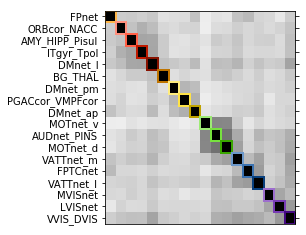

In [30]:
# Matrix 1 (all networks and annotations)
patches = get_better_patches(avg_weight_corr, np.arange(1,19), c=group_18_colors)

ylow = 0
yhigh = 1

dpi=300
scale_factor = 1
height = 80 * scale_factor
width = 105* scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)

ax_dist = f.add_subplot(111)
g = ax_dist.matshow(avg_weight_corr[order, :][:, order], cmap=plt.cm.Greys, vmin=ylow, vmax=yhigh, aspect='auto')

ax_dist.set_xticklabels([])
ax_dist.set_yticklabels([])
for patch in patches:
    ax_dist.add_patch(patch)
    
ax_dist.set_yticks(range(18))
ax_dist.yaxis.set_ticks_position('both')
ax_dist.xaxis.set_ticks_position('none')
ax_dist.set_yticklabels(network_labels.loc[order]['label'].values, fontsize=10);
f.savefig(fig_p / 'corr_network.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'corr_network.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

[(1, '#FFB647'), (2, '#FF907E'), (3, '#FF6047'), (4, '#BF1A00'), (5, '#881200'), (6, '#BF7400'), (7, '#FFEC7E'), (8, '#FFE347'), (9, '#BFA200'), (10, '#9EEB75'), (11, '#77E13E'), (12, '#3AA600'), (13, '#6C98CA'), (14, '#3B72B0'), (15, '#09407D'), (16, '#9D6ECD'), (17, '#783CB5'), (18, '#440981')]


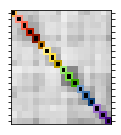

In [31]:
# Matrix 1 (all networks and annotations)
patches = get_better_patches(avg_weight_corr, np.arange(1,19), c=group_18_colors)

ylow = 0
yhigh = 1

dpi=300
scale_factor = 1
height = 45 * scale_factor
width = 40 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)

ax_dist = f.add_subplot(111)
g = ax_dist.matshow(avg_weight_corr[order, :][:, order], cmap=plt.cm.Greys, vmin=ylow, vmax=yhigh, aspect='auto')

ax_dist.set_xticklabels([])
ax_dist.set_yticklabels([])
for patch in patches:
    ax_dist.add_patch(patch)
    
ax_dist.set_yticks(range(18))
ax_dist.yaxis.set_ticks_position('both')
ax_dist.xaxis.set_ticks_position('none')

f.savefig(fig_p / 'corr_network.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'corr_network.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

[(1, '#FFB647'), (2, '#FE2908'), (3, '#BF7400'), (4, '#FED908'), (5, '#52DD07'), (6, '#1258A6'), (7, '#5E12AC')]


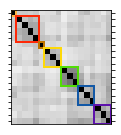

In [32]:
# Matrix 2 (Group 7, no annotations)
patches = get_better_patches(avg_weight_corr, manual_part, c=group_7_colors)

ylow = 0
yhigh = 1

dpi=300
scale_factor = 1
height = 45 * scale_factor
width = 40 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)

ax_dist = f.add_subplot(111)
g = ax_dist.matshow(avg_weight_corr[order, :][:, order], cmap=plt.cm.Greys, vmin=ylow, vmax=yhigh, aspect='auto')

ax_dist.set_xticklabels([])
ax_dist.set_yticklabels([])
for patch in patches:
    ax_dist.add_patch(patch)
    
ax_dist.set_yticks(range(18))
ax_dist.yaxis.set_ticks_position('both')
ax_dist.xaxis.set_ticks_position('none')
ax_dist.set_yticklabels('');
f.savefig(fig_p / 'corr_group.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'corr_group.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

[(1.0, '#FE9D08'), (2.0, '#1258A6')]


/home/surchs/Packages/conda/envs/abide/lib/python3.7/site-packages/matplotlib/figure.py:2317: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure not "


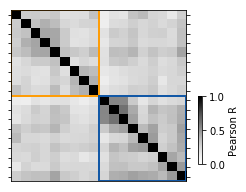

In [33]:
# Matrix 3 (Ensemble 2, no annotations)
patches = get_better_patches(avg_weight_corr, list(np.ones(9)) + list(np.ones(9)*2), c=ens_colors)

ylow = 0
yhigh = 1

dpi=300
scale_factor = 1
height = 80 * scale_factor
width = 80 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
#gs = gridspec.GridSpec(ncols=1, nrows=10, right=0.9)
gs = gridspec.GridSpec(ncols=1, nrows=10)

ax_dist = f.add_subplot(gs[:, :])
cbaxes = f.add_axes([0.95, 0.2, 0.02, 0.3]) 

#f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
g = ax_dist.matshow(avg_weight_corr[order, :][:, order], cmap=plt.cm.Greys, vmin=ylow, vmax=yhigh, aspect='auto')

for patch in patches:
    ax_dist.add_patch(patch)
    
ax_dist.set_yticks(range(18))
ax_dist.yaxis.set_ticks_position('both')
ax_dist.xaxis.set_ticks_position('none')
ax_dist.set_yticklabels('');

cbar = f.colorbar(g, cax=cbaxes)
cbaxes.set_ylabel('Pearson R')
ax_dist.set_xticklabels([])
ax_dist.set_yticklabels([])

f.savefig(fig_p / 'corr_ensemble.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'corr_ensemble.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

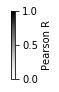

In [34]:
dpi=300
scale_factor = 1
height = 40 * scale_factor
width = 2 * scale_factor

a = np.array([[0,1]])
plt.figure(figsize=(mm2in(width),mm2in(height)))
img = plt.imshow(a, cmap="Greys")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(cax=cax)
cax.set_ylabel('Pearson R', fontsize=10)
cax.set_axis_on()
plt.savefig(fig_p / "colorbar.pdf", bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

[(1.0, '#FE9D08'), (2.0, '#1258A6')]


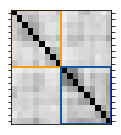

In [35]:
# Matrix 3 (Ensemble 2, no annotations)
patches = get_better_patches(avg_weight_corr, list(np.ones(9)) + list(np.ones(9)*2), c=ens_colors)

ylow = 0
yhigh = 1

dpi=300
scale_factor = 1
height = 45 * scale_factor
width = 40 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)

ax_dist = f.add_subplot(111)
g = ax_dist.matshow(avg_weight_corr[order, :][:, order], cmap=plt.cm.Greys, vmin=ylow, vmax=yhigh, aspect='auto')
for patch in patches:
    ax_dist.add_patch(patch)
    
ax_dist.set_yticks(range(18))
ax_dist.yaxis.set_ticks_position('both')
ax_dist.xaxis.set_ticks_position('none')
ax_dist.set_yticklabels('');

ax_dist.set_xticklabels([])
ax_dist.set_yticklabels([])

f.savefig(fig_p / 'corr_ensemble.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'corr_ensemble.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

## Violin Plots

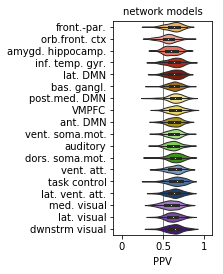

In [29]:
# Violin Plot 1 (all networks, with annotations)

# Network precision
xlow = -0.1
xhigh = 1.1
x_value = 'precision'
lw = 1

fs_xtick = 12
fs_ytick = 18
fs_label = 22

dpi=300
scale_factor = 1
height = 100 * scale_factor
width = 45 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
gs = gridspec.GridSpec(ncols=1, nrows=18, hspace=0)

ax_individual = f.add_subplot(gs[:, 0])

sbn.set_palette(group_18_colors)
#sbn.violinplot(x=x_value, y='network', data=table.iloc[table_order], hue='group', ax=ax_individual, dodge=False, linewidth=lw)
sbn.violinplot(x=x_value, y='network', data=table.iloc[table_order], hue='network', ax=ax_individual, dodge=False, linewidth=lw)

ylim = ax_individual.get_ylim()
ax_individual.vlines(0.5, *ylim, linewidth=lw, color='grey', zorder=0)
ax_individual.set_ylim(ylim)

ax_individual.set_xlim([xlow, xhigh]);
ax_individual.set_ylabel('')
ax_individual.set_xlabel('')
ax_individual.set_xlabel('PPV', labelpad=5, fontsize=10)

ax_individual.tick_params(axis='x', which='major', labelsize=10)
ax_individual.set_xticks((0, 0.5, 1))
ax_individual.set_xticklabels((0, 0.5, 1))

ax_individual.set_yticklabels(())
ax_individual.legend_.remove()
ax_individual.set_title('network models', fontsize=10);
ax_individual.set_yticklabels(network_labels.loc[order]['easy'].values, fontsize=10);

f.savefig(fig_p / 'violin_network_easy_names.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'violin_network_easy_names.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

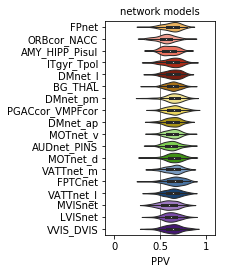

In [36]:
# Violin Plot 1 (all networks, with annotations)

# Network precision
xlow = -0.1
xhigh = 1.1
x_value = 'precision'
lw = 1

fs_xtick = 12
fs_ytick = 18
fs_label = 22

dpi=300
scale_factor = 1
height = 100 * scale_factor
width = 50 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
gs = gridspec.GridSpec(ncols=1, nrows=18, hspace=0)

ax_individual = f.add_subplot(gs[:, 0])

sbn.set_palette(group_18_colors)
#sbn.violinplot(x=x_value, y='network', data=table.iloc[table_order], hue='group', ax=ax_individual, dodge=False, linewidth=lw)
sbn.violinplot(x=x_value, y='network', data=table.iloc[table_order], hue='network', ax=ax_individual, dodge=False, linewidth=lw)

ylim = ax_individual.get_ylim()
ax_individual.vlines(0.5, *ylim, linewidth=lw, color='grey', zorder=0)
ax_individual.set_ylim(ylim)

ax_individual.set_xlim([xlow, xhigh]);
ax_individual.set_ylabel('')
ax_individual.set_xlabel('')
ax_individual.set_xlabel('PPV', labelpad=5, fontsize=10)

ax_individual.tick_params(axis='x', which='major', labelsize=10)
ax_individual.set_xticks((0, 0.5, 1))
ax_individual.set_xticklabels((0, 0.5, 1))

ax_individual.set_yticklabels(())
ax_individual.legend_.remove()
ax_individual.set_title('network models', fontsize=10);
ax_individual.set_yticklabels(network_labels.loc[order]['label'].values, fontsize=10);

f.savefig(fig_p / 'violin_network.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'violin_network.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

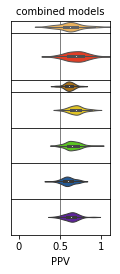

In [37]:
# Violin 2 (group 7, no names)
xlow = -0.1
xhigh = 1.1
x_value = 'precision'
lw = 1

fs_xtick = 12
fs_ytick = 18
fs_label = 22

colors = group_7_colors

dpi=300
scale_factor = 1
height = 100 * scale_factor
width = 45 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
gs = gridspec.GridSpec(ncols=1, nrows=18, hspace=0)

ax_group1 = f.add_subplot(gs[0, 0])
ax_group2 = f.add_subplot(gs[1:5, 0])
ax_group3 = f.add_subplot(gs[5:6, 0])
ax_group4 = f.add_subplot(gs[6:9, 0])
ax_group5 = f.add_subplot(gs[9:12, 0])
ax_group6 = f.add_subplot(gs[12:15, 0])
ax_group7 = f.add_subplot(gs[15:18, 0])

ax_group1.tick_params(axis='both', bottom=False, top=False, right=False, left=False, labelbottom=False, labelleft=False)
ax_group2.tick_params(axis='both', bottom=False, top=False, right=False, left=False, labelbottom=False, labelleft=False)
ax_group3.tick_params(axis='both', bottom=False, top=False, right=False, left=False, labelbottom=False, labelleft=False)
ax_group4.tick_params(axis='both', bottom=False, top=False, right=False, left=False, labelbottom=False, labelleft=False)
ax_group5.tick_params(axis='both', bottom=False, top=False, right=False, left=False, labelbottom=False, labelleft=False)
ax_group6.tick_params(axis='both', bottom=False, top=False, right=False, left=False, labelbottom=False, labelleft=False)
ax_group7.tick_params(axis='both', bottom=True, top=False, right=False, left=False, labelbottom=True, labelleft=False)

sbn.violinplot(x=x_value, y='network', data=table_combined.query('network=="group_1"'), color=colors[0], ax=ax_group1, linewidth=lw);
ax_group1.set_ylabel('')
ax_group1.set_yticks([])

ylim = ax_group1.get_ylim()
ax_group1.vlines(0.5, *ylim, linewidth=lw, color='grey', zorder=0)
ax_group1.set_ylim(ylim)

ax_group1.set_xlabel('')
ax_group1.set_xlim([xlow, xhigh]);
ax_group1.set_title('combined models', fontsize=10);

sbn.violinplot(x=x_value, y='network', data=table_combined.query('network=="group_2"'), color=colors[1], ax=ax_group2, linewidth=lw);
ax_group2.set_xlabel('')
ax_group2.vlines(0.5, *[-1.8, 1.8], linewidth=lw, color='grey', zorder=0)
ax_group2.set_ylim([-1.8, 1.8])
ax_group2.set_ylabel('')
ax_group2.set_xlim([xlow, xhigh]);

sbn.violinplot(x=x_value, y='network', data=table_combined.query('network=="group_3"'), color=colors[2], ax=ax_group3, linewidth=lw);
ax_group3.set_xlabel('')
ax_group3.set_ylabel('')

ylim = ax_group3.get_ylim()
ax_group3.vlines(0.5, *ylim, linewidth=lw, color='grey', zorder=0)
ax_group3.set_ylim(ylim)

ax_group3.set_xlim([xlow, xhigh]);

sbn.violinplot(x=x_value, y='network', data=table_combined.query('network=="group_4"'), color=colors[3], ax=ax_group4, linewidth=lw);
ax_group4.set_xlabel('')
ax_group4.vlines(0.5, *[-1.5, 1.5], linewidth=lw, color='grey', zorder=0)
ax_group4.set_ylim([-1.5, 1.5])
ax_group4.set_ylabel('')
ax_group4.set_xlim([xlow, xhigh]);

sbn.violinplot(x=x_value, y='network', data=table_combined.query('network=="group_5"'), color=colors[4], ax=ax_group5, linewidth=lw);
ax_group5.set_xlabel('')
ax_group5.vlines(0.5, *[-1.5, 1.5], linewidth=lw, color='grey', zorder=0)
ax_group5.set_ylim([-1.5, 1.5])
ax_group5.set_ylabel('')
ax_group5.set_xlim([xlow, xhigh]);

sbn.violinplot(x=x_value, y='network', data=table_combined.query('network=="group_6"'), color=colors[5], ax=ax_group6, linewidth=lw);
ax_group6.set_xlabel('')
ax_group6.vlines(0.5, *[-1.5, 1.5], linewidth=lw, color='grey', zorder=0)
ax_group6.set_ylim([-1.5, 1.5])
ax_group6.set_ylabel('')
ax_group6.set_xlim([xlow, xhigh]);

sbn.violinplot(x=x_value, y='network', data=table_combined.query('network=="group_7"'), color=colors[6], ax=ax_group7, linewidth=lw);
ax_group7.vlines(0.5, *[-1.5, 1.5], linewidth=lw, color='grey', zorder=0)
ax_group7.set_ylim([-1.5, 1.5])
ax_group7.set_ylabel('')
ax_group7.set_xlabel('')
ax_group7.set_xlabel('PPV', labelpad=5, fontsize=10)

ax_group7.tick_params(axis='x', which='major', labelsize=10)
ax_group7.set_xticks((0, 0.5, 1))
ax_group7.set_xticklabels((0, 0.5, 1))

ax_group7.set_xlim([xlow, xhigh]);

f.savefig(fig_p / 'violin_group.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'violin_group.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

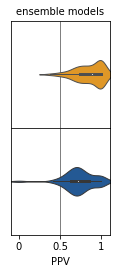

In [38]:
# Violin 2 (ensemble, no names)
xlow = -0.1
xhigh = 1.1
x_value = 'precision'
lw = 1

fs_xtick = 12
fs_ytick = 18
fs_label = 22

split_colors = ens_colors

dpi=300
scale_factor = 1
height = 100 * scale_factor
width = 45 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
gs = gridspec.GridSpec(ncols=1, nrows=18, hspace=0)

ax_split1 = f.add_subplot(gs[:9, 0])
ax_split2 = f.add_subplot(gs[9:, 0])
ax_split1.tick_params(axis='both', bottom=False, top=False, right=False, left=False, labelbottom=False, labelleft=False)
ax_split2.tick_params(axis='both', bottom=True, top=False, right=False, left=False, labelbottom=True, labelleft=False)


sbn.violinplot(x=x_value, y='network', data=table_split.query('network=="group_1"'), color=split_colors[0], 
            ax=ax_split1, showmeans=True, linewidth=lw);
ax_split1.set_ylabel('')
ax_split1.vlines(0.5, *[-1.5, 1.5], linewidth=lw, color='grey', zorder=0)
ax_split1.set_ylim([-1.5, 1.5])
ax_split1.set_yticks([])
ax_split1.set_xlabel('')
ax_split1.set_xlim([xlow, xhigh]);
ax_split1.set_title('ensemble models', fontsize=10);

sbn.violinplot(x=x_value, y='network', data=table_split.query('network=="group_2"'), color=split_colors[1], 
            ax=ax_split2, showmeans=True, linewidth=lw);
ax_split2.set_ylabel('')
ax_split2.set_xlabel('')
ax_split2.set_xlabel('PPV', labelpad=5, fontsize=10)

ax_split2.tick_params(axis='x', which='major', labelsize=10)
ax_split2.set_xticks((0, 0.5, 1))
ax_split2.set_xticklabels((0, 0.5, 1))
ax_split2.vlines(0.5, *[-1.5, 1.5], linewidth=lw, color='grey', zorder=0)
ax_split2.set_ylim([-1.5, 1.5])
ax_split2.set_yticks([])
ax_split2.set_xlim([xlow, xhigh]);

f.savefig(fig_p / 'violin_ensemble.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'violin_ensemble.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

## Networks

In [39]:
order = np.array([18,  3,  9,  5, 16,  1, 13,  4, 12,  2,  7, 10, 11,  6, 17,  8, 14,
       15])-1

In [40]:
# Manual partition
part_dict = {1: [18],
             2: [3, 9, 5, 16],
             3: [1],
             4: [13, 4, 12],
             5: [2, 7, 10],
             6: [11, 6, 17],
             7: [8, 14, 15]
            }
manual_part = np.array([p for i in order  for p, v in part_dict.items() if i+1 in v])

In [41]:
#cmp = LinearSegmentedColormap.from_list('lala', colors, N=7)
cmp_7 = LinearSegmentedColormap.from_list('lala', group_7_colors, N=7)

cmp_2 = LinearSegmentedColormap.from_list('lala', ens_colors, N=2)

In [42]:
cmp = LinearSegmentedColormap.from_list('lala', group_18_colors, N=18)

In [43]:
ens_1 = [1, 2, 3, 4]
ens_2 = [5, 6, 7]

In [44]:
# Remap atlas numbers to the 7 groups
atlas = atlas_i.get_data().astype(int)
atlas_masked = np.zeros(shape=(atlas.shape))
atlas_ens1 = np.zeros(shape=(atlas.shape))
atlas_ens2 = np.zeros(shape=(atlas.shape))
atlas_ens = np.zeros(shape=(atlas.shape))
for i in np.arange(1,8):    
    for j in part_dict[i]:
        # convert j to real j
        real_j = network_labels.iloc[j-1].roi
        if i <=4:
            atlas_ens1[atlas==real_j] = i
            atlas_masked[atlas==real_j] = 1
        else:
            atlas_ens2[atlas==real_j] = i
            atlas_masked[atlas==real_j] = 2
        atlas_ens[atlas==real_j] = i
atlas_masked_i = nib.Nifti1Image(atlas_masked, affine=atlas_i.affine, header=atlas_i.header)
atlas_ens_i = nib.Nifti1Image(atlas_ens, affine=atlas_i.affine, header=atlas_i.header)
atlas_ens1_i = nib.Nifti1Image(atlas_ens1, affine=atlas_i.affine, header=atlas_i.header)
atlas_ens2_i = nib.Nifti1Image(atlas_ens2, affine=atlas_i.affine, header=atlas_i.header)

In [45]:
# Remap atlas numbers to the 18 ordering
atlas = atlas_i.get_data().astype(int)
atlas_ens = np.zeros(shape=(atlas.shape))

for idx, val in enumerate(order):
    real_j = network_labels.iloc[val].roi
    atlas_ens[atlas==real_j] = idx+1
atlas_ens_i = nib.Nifti1Image(atlas_ens, affine=atlas_i.affine, header=atlas_i.header)

In [46]:
atlas_comb = np.zeros(shape=(atlas.shape))

for comb in part_dict.keys():
    for val in part_dict[comb]:
        real_j = network_labels.iloc[val-1].roi
        atlas_comb[atlas==real_j] = comb
atlas_comb_i = nib.Nifti1Image(atlas_comb, affine=atlas_i.affine, header=atlas_i.header)

## Triple brains

In [73]:
coords = (10,5,0)

/home/surchs/Packages/conda/envs/abide/lib/python3.7/site-packages/nilearn/plotting/displays.py:1239: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if (not isinstance(cut_coords, collections.Sequence) and
/home/surchs/Packages/conda/envs/abide/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


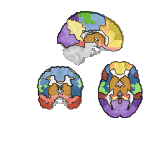

In [48]:
# Individual brain slices and both networks together
dpi=300
scale_factor = 1
height = 50 * scale_factor
width = 50 * scale_factor

lw=0.5

fig = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=2, hspace=-0.1)

ax_sag = fig.add_subplot(gs[0, :])
ax_cor = fig.add_subplot(gs[1, 0])
ax_ax = fig.add_subplot(gs[1,1])

g = nlp.plot_roi(atlas_ens_i, cmap=cmp, cut_coords=(coords[0],), display_mode='x', axes=ax_sag, vmin=1, 
                 vmax=18, draw_cross=False, annotate=False, black_bg=False);
#g.annotate(fontsize=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=lw)

g = nlp.plot_roi(atlas_ens_i, cmap=cmp, cut_coords=(coords[1],), display_mode='y', axes=ax_cor, vmin=1, vmax=18, draw_cross=False, 
             annotate=False, black_bg=False);
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=lw)
#g.annotate(fontsize=10)

g = nlp.plot_roi(atlas_ens_i, cmap=cmp, cut_coords=(coords[2],), display_mode='z', axes=ax_ax, vmin=1, vmax=18, 
             draw_cross=False, annotate=False, black_bg=False);
#g.annotate(fontsize=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=lw)

fig.savefig(fig_p / 'brain_x_individual.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
fig.savefig(fig_p / 'brain_x_individual.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

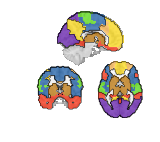

In [49]:
# combined networks
dpi=300
scale_factor = 1
height = 50 * scale_factor
width = 50 * scale_factor

lw=0.5

fig = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=2, hspace=-0.1)

ax_sag = fig.add_subplot(gs[0, :])
ax_cor = fig.add_subplot(gs[1, 0])
ax_ax = fig.add_subplot(gs[1,1])

g = nlp.plot_roi(atlas_comb_i, cmap=cmp_7, cut_coords=(coords[0],), display_mode='x', axes=ax_sag, vmin=1, 
                 vmax=7, draw_cross=False, annotate=False, black_bg=False);
#g.annotate(fontsize=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=lw)

g = nlp.plot_roi(atlas_comb_i, cmap=cmp_7, cut_coords=(coords[1],), display_mode='y', axes=ax_cor, vmin=1, vmax=7, draw_cross=False, 
             annotate=False, black_bg=False);
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=lw)
#g.annotate(fontsize=10)

g = nlp.plot_roi(atlas_comb_i, cmap=cmp_7, cut_coords=(coords[2],), display_mode='z', axes=ax_ax, vmin=1, vmax=7, 
             draw_cross=False, annotate=False, black_bg=False);
#g.annotate(fontsize=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=lw)

fig.savefig(fig_p / 'brain_x_combined.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
fig.savefig(fig_p / 'brain_x_combined.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

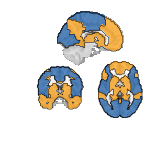

In [50]:
# ensemble
dpi=300
scale_factor = 1
height = 50 * scale_factor
width = 50 * scale_factor

lw=0.5

fig = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=2, hspace=-0.1)

ax_sag = fig.add_subplot(gs[0, :])
ax_cor = fig.add_subplot(gs[1, 0])
ax_ax = fig.add_subplot(gs[1,1])

g = nlp.plot_roi(atlas_masked_i, cmap=cmp_2, cut_coords=(coords[0],), display_mode='x', axes=ax_sag, vmin=1, 
                 vmax=2, draw_cross=False, annotate=False, black_bg=False);
#g.annotate(fontsize=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=lw)

g = nlp.plot_roi(atlas_masked_i, cmap=cmp_2, cut_coords=(coords[1],), display_mode='y', axes=ax_cor, vmin=1, vmax=2, draw_cross=False, 
             annotate=False, black_bg=False);
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=lw)
#g.annotate(fontsize=10)

g = nlp.plot_roi(atlas_masked_i, cmap=cmp_2, cut_coords=(coords[2],), display_mode='z', axes=ax_ax, vmin=1, vmax=2, 
             draw_cross=False, annotate=False, black_bg=False);
#g.annotate(fontsize=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=lw)

fig.savefig(fig_p / 'brain_x_ensemble.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
fig.savefig(fig_p / 'brain_x_ensemble.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

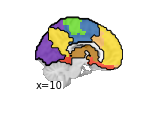

In [51]:
dpi=300
scale_factor = 1
height = 35 * scale_factor
width = 50 * scale_factor

fig = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
ax = fig.add_subplot(111)
g = nlp.plot_roi(atlas_comb_i, cmap=cmp_7, cut_coords=(coords[0],), display_mode='x', axes=ax, vmin=1, 
                 vmax=7, draw_cross=False, annotate=False, black_bg=False);
g.annotate(fontsize=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=1)

In [52]:
group_7_colors

['#FFB647', '#FE2908', '#BF7400', '#FED908', '#52DD07', '#1258A6', '#5E12AC']

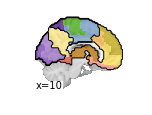

In [53]:
# Individual brain slices and both networks together
dpi=300
scale_factor = 1
height = 35 * scale_factor
width = 50 * scale_factor

fig = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
ax = fig.add_subplot(111)
g = nlp.plot_roi(atlas_ens_i, cmap=cmp, cut_coords=(coords[0],), display_mode='x', axes=ax, vmin=1, 
                 vmax=18, draw_cross=False, annotate=False, black_bg=False);
g.annotate(fontsize=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=1)

fig.savefig(fig_p / 'brain_x.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
fig.savefig(fig_p / 'brain_x.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

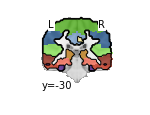

In [72]:
# Individual brain slices and both networks together
dpi=300
scale_factor = 1
height = 35 * scale_factor
width = 50 * scale_factor

fig = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
ax = fig.add_subplot(111)
g = nlp.plot_roi(atlas_ens_i, cmap=cmp, cut_coords=(coords[1],), display_mode='y', axes=ax, vmin=1, vmax=18, draw_cross=False, 
             annotate=False, black_bg=False);
g.annotate(fontsize=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=1)
fig.savefig(fig_p / 'brain_y.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
fig.savefig(fig_p / 'brain_y.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)

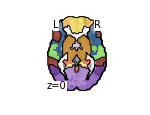

In [55]:
# Individual brain slices and both networks together
dpi=300
scale_factor = 1
height = 35 * scale_factor
width = 50 * scale_factor

fig = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
ax = fig.add_subplot(111)
g = nlp.plot_roi(atlas_ens_i, cmap=cmp, cut_coords=(coords[2],), display_mode='z', axes=ax, vmin=1, vmax=18, 
             draw_cross=False, annotate=False, black_bg=False);
g.annotate(fontsize=10)
g.add_contours(atlas_masked_i, filled=False, alpha=1, levels=[0.5, 1.5], colors='black', linewidths=1)
fig.savefig(fig_p / 'brain_z.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
fig.savefig(fig_p / 'brain_z.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)